# Preprocessing for SSIT of the Cardiac Dataset
Steps: <br>
Load in data<br>
Downsample <br>
Clean Data <br>
Demultiplex w/ hashtags <br>
Integrate Data <br>
Identify groups <br>
Embed in lower dimensions <br>



In [1]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import os


/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in Data

In [2]:
# Set the path to the dataset folder
dataset_folder = "/home/formanj/scRNAseq_model/UpDownProject/Datasets/Cardiac"

# Get the list of .h5 files in the dataset folder
h5_files = [file for file in os.listdir(dataset_folder) if file.endswith('.h5')]

# Load each .h5 file into scanpy
adata_list = []
for file in h5_files:
    file_path = os.path.join(dataset_folder, file)
    adata_list.append(sc.read_10x_h5(file_path, gex_only=False))


for i in range(len(adata_list)):
    adata_list[i].var_names_make_unique()
    adata_list[i].uns['Dataset_name'] = f'Dataset {i}'
    adata_list[i].obs['batch'] = [f'batch {i}']*adata_list[i].shape[0]
    print([j for j in adata_list[i].var_names if j.endswith('-1')])

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


['IGKV1OR1-1', 'ERVMER61-1', 'TBCE-1', 'IGKV4-1', 'IGKV1OR2-1', 'IGKV2OR2-1', 'LINC01238-1', 'CYB561D2-1', 'NKX1-1', 'ERVH-1', 'ERVMER34-1', 'NKX6-1', 'MATR3-1', 'ERVFRD-1', 'ERV3-1', 'ERVW-1', 'TRBV3-1', 'TRBV4-1', 'TRBV5-1', 'TRBV6-1', 'TRBV7-1', 'TRBV8-1', 'TRBV10-1', 'TRBV11-1', 'TRBV12-1', 'TRBV20-1', 'TRBV21-1', 'TRBV22-1', 'TRBV23-1', 'TRBV24-1', 'TRBV25-1', 'TRBV29-1', 'TRBJ1-1', 'TRBJ2-1', 'NKX3-1', 'IGLV8OR8-1', 'IGKV1OR9-1', 'LINC01505-1', 'HSPA14-1', 'IGKV1OR10-1', 'KRTAP5-1', 'TRAV1-1', 'TRAV8-1', 'TRAV9-1', 'TRAV12-1', 'TRAV13-1', 'TRAV26-1', 'TRAV38-1', 'NKX2-1', 'IGHD1-1', 'IGHV6-1', 'IGHVII-1-1', 'IGHVIII-2-1', 'IGHV7-4-1', 'IGHVIII-5-1', 'IGHV5-10-1', 'IGHVIII-11-1', 'IGHVIII-13-1', 'IGHVII-15-1', 'IGHVIII-16-1', 'IGHVII-22-1', 'IGHVIII-25-1', 'IGHVIII-26-1', 'IGHVII-28-1', 'IGHVII-30-1', 'IGHVII-33-1', 'IGHV7-34-1', 'IGHVIII-38-1', 'IGHVII-40-1', 'IGHVII-43-1', 'IGHVIV-44-1', 'IGHVII-46-1', 'IGHVIII-47-1', 'IGHVII-49-1', 'IGHVIII-51-1', 'IGHVII-53-1', 'IGHVII-60-1', 

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Downsample

In [3]:
for i in range(len(adata_list)):
    print(adata_list[i].shape)
    sc.pp.filter_cells(adata_list[i], min_genes=200)
    sc.pp.filter_genes(adata_list[i], min_cells=10)
    print(adata_list[i].shape)

(17820, 36613)
(17678, 24819)
(13364, 36613)
(13348, 23343)
(18015, 36613)
(18008, 23480)


Demultiplex

In [4]:
for i in range(len(adata_list)):
    HTO_list = [j for j in adata_list[i].var_names if 'DAY' in j]
    print(HTO_list)
    print(adata_list[i].obs)
    for j in HTO_list:
        adata_list[i].obs[j] = adata_list[i][:,j].X.toarray().flatten()
    adata_list[i] = adata_list[i][:, [k for k in adata_list[i].var_names if k not in HTO_list]]
    print(adata_list[i].obs)
    sc.external.pp.hashsolo(adata_list[i], cell_hashing_columns=HTO_list)


['LMNA_DAY0', 'LMNA_DAY7', 'LMNA_DAY11', 'LMNA_DAY13', 'LMNA_DAY15', 'LMNA_DAY30', 'WTC_DAY0', 'WTC_DAY7', 'WTC_DAY11', 'WTC_DAY13', 'WTC_DAY15', 'WTC_DAY30']
                      batch  n_genes
AAACCCAAGAAATCCA-1  batch 0     1821
AAACCCAAGAGCATAT-1  batch 0     7029
AAACCCAAGAGCATTA-1  batch 0     6769
AAACCCAAGAGGCGGA-1  batch 0     8701
AAACCCAAGATTCGCT-1  batch 0     1129
...                     ...      ...
TTTGTTGTCATTCCTA-1  batch 0     8772
TTTGTTGTCCTCACTG-1  batch 0     2315
TTTGTTGTCGAGTCCG-1  batch 0     5613
TTTGTTGTCGAGTGGA-1  batch 0     1837
TTTGTTGTCTATACGG-1  batch 0     7386

[17678 rows x 2 columns]


                      batch  n_genes  LMNA_DAY0  LMNA_DAY7  LMNA_DAY11  \
AAACCCAAGAAATCCA-1  batch 0     1821      138.0      147.0       259.0   
AAACCCAAGAGCATAT-1  batch 0     7029      107.0      118.0       205.0   
AAACCCAAGAGCATTA-1  batch 0     6769     4794.0      112.0      4491.0   
AAACCCAAGAGGCGGA-1  batch 0     8701      105.0      124.0      1905.0   
AAACCCAAGATTCGCT-1  batch 0     1129       88.0      103.0       195.0   
...                     ...      ...        ...        ...         ...   
TTTGTTGTCATTCCTA-1  batch 0     8772     6124.0       82.0       961.0   
TTTGTTGTCCTCACTG-1  batch 0     2315        5.0        4.0         5.0   
TTTGTTGTCGAGTCCG-1  batch 0     5613       90.0     8664.0       713.0   
TTTGTTGTCGAGTGGA-1  batch 0     1837      101.0      131.0       198.0   
TTTGTTGTCTATACGG-1  batch 0     7386     6544.0       83.0       168.0   

                    LMNA_DAY13  LMNA_DAY15  LMNA_DAY30  WTC_DAY0  WTC_DAY7  \
AAACCCAAGAAATCCA-1         0.0   

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/external/pp/_hashsolo.py:68: RuntimeWarning: divide by zero encountered in divide
  lam = 1 / np.var(data) if len(data) > 1 else lam_o
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/external/pp/_hashsolo.py:71: RuntimeWarning: invalid value encountered in scalar multiply
  (np.mean(data) * n * lam + mu_o * lam_o) / lam_n if len(data) > 0 else mu_o
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/external/pp/_hashsolo.py:379: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["most_likely_hypothesis"] = results.loc[


['LMNA_DAY0', 'LMNA_DAY7', 'LMNA_DAY13', 'LMNA_DAY15', 'LMNA_DAY30', 'WTC_DAY7', 'WTC_DAY11', 'WTC_DAY13', 'WTC_DAY15', 'WTC_DAY30']
                      batch  n_genes
AAACCCAAGAACAAGG-1  batch 1     7259
AAACCCAAGAGTAACT-1  batch 1      740
AAACCCAAGCATGATA-1  batch 1     7305
AAACCCACAACAGAGC-1  batch 1     6821
AAACCCACAGTTTCGA-1  batch 1     3492
...                     ...      ...
TTTGTTGGTCGACTGC-1  batch 1     3430
TTTGTTGGTGCCTAAT-1  batch 1     5934
TTTGTTGTCAGTGTGT-1  batch 1     4473
TTTGTTGTCCTGTTGC-1  batch 1     5653
TTTGTTGTCTGGTCAA-1  batch 1     4055

[13348 rows x 2 columns]
                      batch  n_genes  LMNA_DAY0  LMNA_DAY7  LMNA_DAY13  \
AAACCCAAGAACAAGG-1  batch 1     7259        0.0        0.0       164.0   
AAACCCAAGAGTAACT-1  batch 1      740        0.0        0.0        14.0   
AAACCCAAGCATGATA-1  batch 1     7305        0.0        0.0       196.0   
AAACCCACAACAGAGC-1  batch 1     6821        0.0        0.0       356.0   
AAACCCACAGTTTCGA-1  batch 1

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/external/pp/_hashsolo.py:379: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["most_likely_hypothesis"] = results.loc[


['LMNA_DAY1', 'LMNA_DAY2', 'LMNA_DAY3', 'LMNA_DAY4', 'LMNA_DAY5', 'LMNA_DAY6', 'WTC_DAY1', 'WTC_DAY2', 'WTC_DAY3', 'WTC_DAY4', 'WTC_DAY5', 'WTC_DAY6']
                      batch  n_genes
AAACCCAAGCAACAAT-1  batch 2     6911
AAACCCAAGCTACTAC-1  batch 2     7091
AAACCCAAGCTGACAG-1  batch 2     4927
AAACCCAAGGTCGTGA-1  batch 2     5267
AAACCCACAAGCTGTT-1  batch 2     3027
...                     ...      ...
TTTGTTGTCCTTGACC-1  batch 2     4144
TTTGTTGTCGGAAACG-1  batch 2     3962
TTTGTTGTCTATCGGA-1  batch 2     3009
TTTGTTGTCTCAACGA-1  batch 2     5450
TTTGTTGTCTGTCAGA-1  batch 2     2779

[18008 rows x 2 columns]
                      batch  n_genes  LMNA_DAY1  LMNA_DAY2  LMNA_DAY3  \
AAACCCAAGCAACAAT-1  batch 2     6911    10150.0       28.0       22.0   
AAACCCAAGCTACTAC-1  batch 2     7091     4426.0     4445.0       33.0   
AAACCCAAGCTGACAG-1  batch 2     4927       23.0       32.0      401.0   
AAACCCAAGGTCGTGA-1  batch 2     5267       30.0       45.0      125.0   
AAACCCACAAGCTG

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/external/pp/_hashsolo.py:379: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["most_likely_hypothesis"] = results.loc[


In [5]:
for i in range(len(adata_list)):
    adata_list[i] = adata_list[i][adata_list[i].obs['Classification'] != 'Negative', :]

Clean Data

/tmp/ipykernel_713757/969003803.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_list[i].var['mt'] = adata_list[i].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


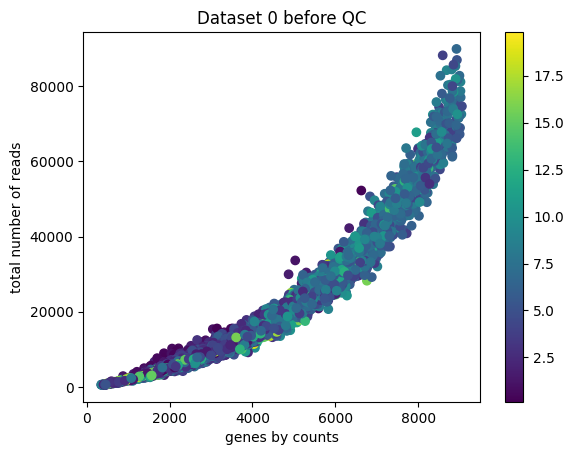

876.48 to 8317.76


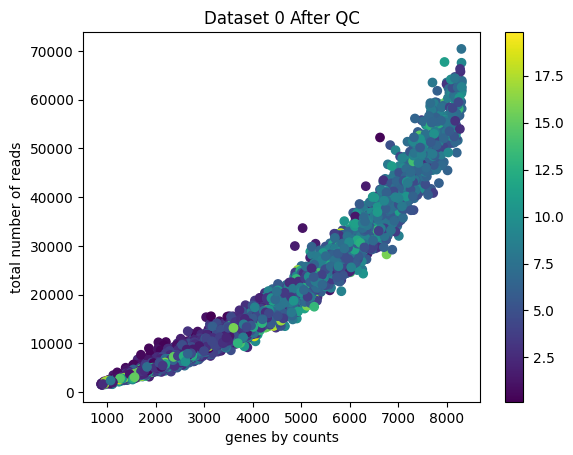

/tmp/ipykernel_713757/969003803.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_list[i].var['mt'] = adata_list[i].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


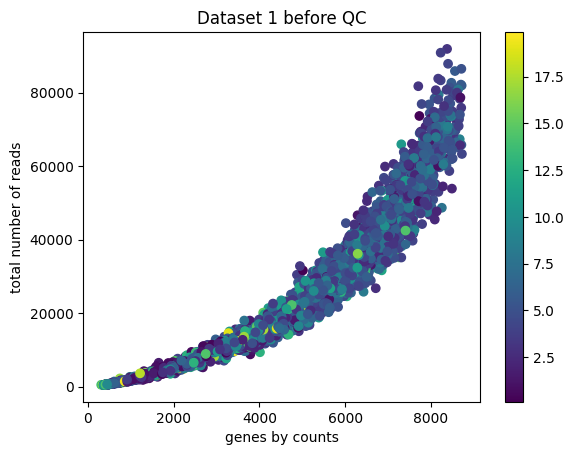

444.68 to 8170.0


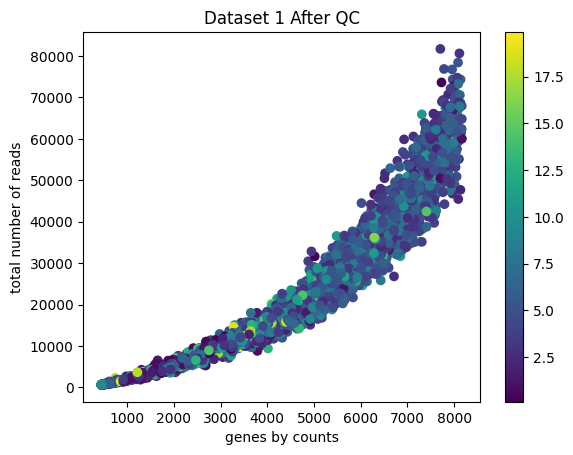

/tmp/ipykernel_713757/969003803.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_list[i].var['mt'] = adata_list[i].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


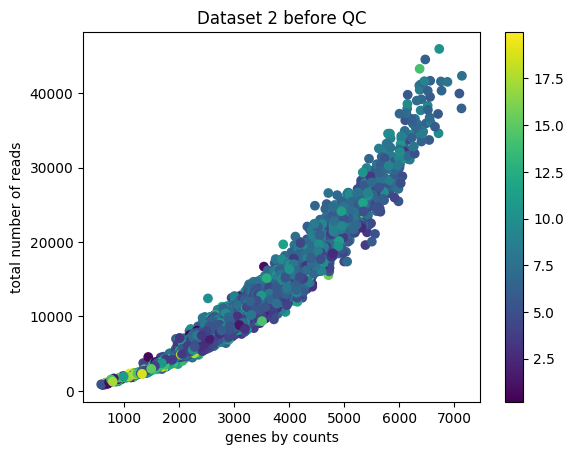

1679.0 to 5699.0999999999885


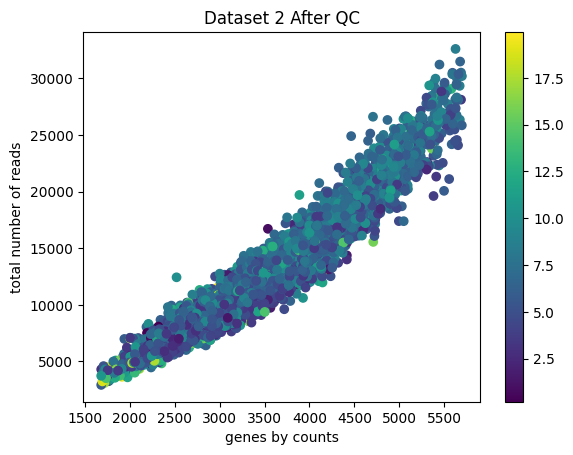

In [10]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

for i in range(len(adata_list)):
    adata_list[i].var['mt'] = adata_list[i].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    adata_list[i].var['ribo'] = adata_list[i].var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata_list[i], qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    #sc.pl.violin(adata[i_d], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
    
    plt.scatter(adata_list[i].obs['n_genes_by_counts'], adata_list[i].obs['total_counts'], c=adata_list[i].obs['pct_counts_mt'])
    plt.xlabel('genes by counts')
    plt.ylabel('total number of reads')
    plt.title(adata_list[i].uns['Dataset_name'] + ' before QC')
    plt.colorbar()
    plt.show()
    
    upper_lim = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .02)
    print(f'{lower_lim} to {upper_lim}')
    adata_list[i] = adata_list[i][(adata_list[i].obs.n_genes_by_counts < upper_lim) & (adata_list[i].obs.n_genes_by_counts > lower_lim)]
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mt < 20]
    
    plt.scatter(adata_list[i].obs['n_genes_by_counts'], adata_list[i].obs['total_counts'], c=adata_list[i].obs['pct_counts_mt'])
    plt.xlabel('genes by counts')
    plt.ylabel('total number of reads')
    plt.title(adata_list[i].uns['Dataset_name'] + ' After QC')
    plt.colorbar()
    plt.show()
    
    # remove stimulated group from data
    adata_list[i] = adata_list[i][[j for j in adata_list[i].obs_names if 'WTC' in adata_list[i].obs['Classification'][j]], :]

Integration

In [11]:
adata = sc.concat(adata_list)
sc.pp.filter_genes(adata, min_cells = 10)
adata.X = csr_matrix(adata.X)
adata.write_h5ad('combined.h5ad')

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
#%% Normilization
# Unequal waiting of genes
sc.pp.filter_genes(adata, min_cells = 100)

adata.layers['counts'] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=5000)

adata.raw = adata
#adata = adata[:, adata.var.highly_variable]
#sc.pp.regress_out(adata[i_d], ['total_counts', 'pct_counts_mt']) # regresses out effect
#sc.pp.scale(adata[i_d], max_value=10) # treats all genes the same
    

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [13]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["batch"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
#torch.set_float32_matmul_precision('medium' | 'high')
model = scvi.model.SCVI(adata)
model.train() #may take a while without GPU

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|██████████| 400/400 [24:35<00:00,  2.55s/it, v_num=1, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [24:35<00:00,  3.69s/it, v_num=1, train_loss_step=1.02e+4, train_loss_epoch=1.02e+4]


Latent Represnetation 

In [15]:

adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
adata.write_h5ad('ProcessedData.h5ad')

In [2]:
adata = sc.read_h5ad('ProcessedData.h5ad')

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

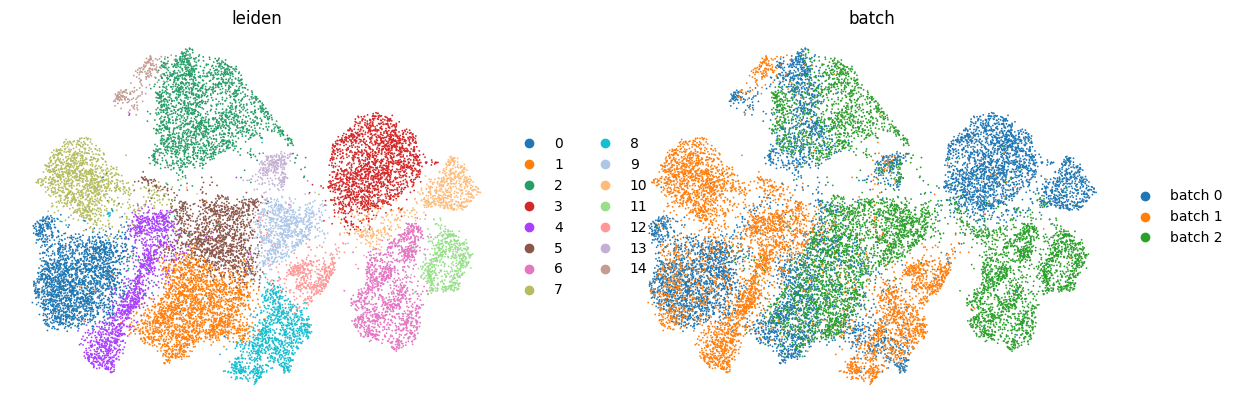

In [4]:

sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color = ['leiden', 'batch'], frameon = False)

Save data

In [6]:
data = {
    'Classification': adata.obs['Classification'],
    'UMAP X(0)': adata.obsm['X_scVI'][:, 0],
    'UMAP X(1)': adata.obsm['X_scVI'][:, 1],
    'leiden': adata.obs['leiden'],
    'batch': adata.obs['batch']
}


data = pd.DataFrame.from_dict(data)

data.to_csv('SSIT_Data_V1.csv')